## Notbook that plots a few (fancy) maps in 

In [17]:
from netCDF4 import Dataset as nc, num2date
import numpy as np
import pandas as pd
import sys, os
import matplotlib
from matplotlib import pyplot as plt, cm
from datetime import timedelta
from mpl_toolkits.basemap import Basemap, cm as cm_b
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

Define all filenames

In [18]:
cpolF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_1998-2017.nc')
cmorphF = os.path.join(os.environ['HOME'], 'Data', 'Darwin', 'netcdf', 'Cmorph_1998-2010.nc')
outDir = os.path.join(os.environ['HOME'], 'Data','Extremes' ,'CPOL', 'Plot')
DFFile = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_MonsoonPhases-dates.hdf5')

Define the dates for plotting

In [25]:
periods = {}
keys = []
with pd.HDFStore(DFFile,'r') as h5:
    for key in h5.keys():
        keys.append(key[1:])
for key in keys:
    periods[key] = pd.read_hdf(DFFile,key)
periods['breaks'].start

#start, end = ('1999-01-01','1999-01-29'), ('1999-01-02','1999-02-01')
start, end = ('2005-02-15',), ('2005-02-21',)
T =[]
for s, e in zip(start, end):
    T += list(pd.date_range(s, e, freq='10min').to_pydatetime())
T = pd.DatetimeIndex(T)
T


DatetimeIndex(['2005-02-15 00:00:00', '2005-02-15 00:10:00',
               '2005-02-15 00:20:00', '2005-02-15 00:30:00',
               '2005-02-15 00:40:00', '2005-02-15 00:50:00',
               '2005-02-15 01:00:00', '2005-02-15 01:10:00',
               '2005-02-15 01:20:00', '2005-02-15 01:30:00',
               ...
               '2005-02-20 22:30:00', '2005-02-20 22:40:00',
               '2005-02-20 22:50:00', '2005-02-20 23:00:00',
               '2005-02-20 23:10:00', '2005-02-20 23:20:00',
               '2005-02-20 23:30:00', '2005-02-20 23:40:00',
               '2005-02-20 23:50:00', '2005-02-21 00:00:00'],
              dtype='datetime64[ns]', length=865, freq=None)

Get all timesteps

### Plot the CPOL vs CMORPH map
Create the maps first, for this get the metadata

In [22]:
with nc(cmorphF) as fnc:
    lon_cm = fnc.variables['lon'][:]
    lat_cm = fnc.variables['lat'][:]
    t_cm = pd.DatetimeIndex(num2date(fnc.variables['time'][:], fnc.variables['time'].units))
    with nc(cpolF) as gnc:
        lon_cp = gnc.variables['lon'][:]
        lat_cp = gnc.variables['lat'][:]
        cpol_times ={}
        for tt in ('10min', '1h', '3h', '6h'):
            cpol_times[tt] = pd.DatetimeIndex(num2date(gnc[tt].variables['time'][:], gnc[tt].variables['time'].units))
        #tt = np.array([(np.where(t_cm == p)[0][0], np.where(t_cp == p)[0][0])for p in T if p in t_cp and p in t_cm])
        idx = []
        for tt in T:
            if tt in cpol_times['10min']:
                try:
                    i10m=np.where(cpol_times['10min'] == tt)[0][0]
                    t1h = pd.Timestamp(tt.year, tt.month, tt.day, tt.hour)
                    i1h = np.where(cpol_times['1h'] == t1h)[0][0]
                    c = np.array(3*list(range(int(24/3))));c.sort();c*=3
                    i3h = np.where(cpol_times['3h'] == pd.Timestamp(tt.year, tt.month, tt.day, c[tt.hour]))[0][0]
                    i3hc = np.where(t_cm == pd.Timestamp(tt.year, tt.month, tt.day, c[tt.hour]))[0][0]
                    c = np.array(6*list(range(int(24/6))));c*=6;c.sort()
                    i6h = np.where(cpol_times['6h'] == pd.Timestamp(tt.year, tt.month, tt.day, c[tt.hour]))[0][0]
                    idx.append((i10m,i1h,i3h,i6h,i3hc))
                except IndexError:
                    pass
        
        idx = np.array(idx)
        rr_cp = {}
        for n,tt in enumerate(('10min', '1h', '3h', '6h')):
            rr_cp[tt] = gnc[tt].variables['rain_rate'][idx[:,n]]
    rr_cm = fnc.variables['precip'][idx[:,-1]]

In [23]:
m_cm = Basemap(llcrnrlat=min(lat_cm), llcrnrlon=min(lon_cm), urcrnrlat=max(lat_cm), urcrnrlon=max(lon_cm), resolution='i')
matplotlib.rcParams['figure.figsize'] = [30,30]
avg_type = {'10min':'(10 Min.)', '1h': '(1 hly)', '3h': '(3 hly)', '6h': '(6 hly)'}

In [135]:
len()

578

/usr/lib/python3/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


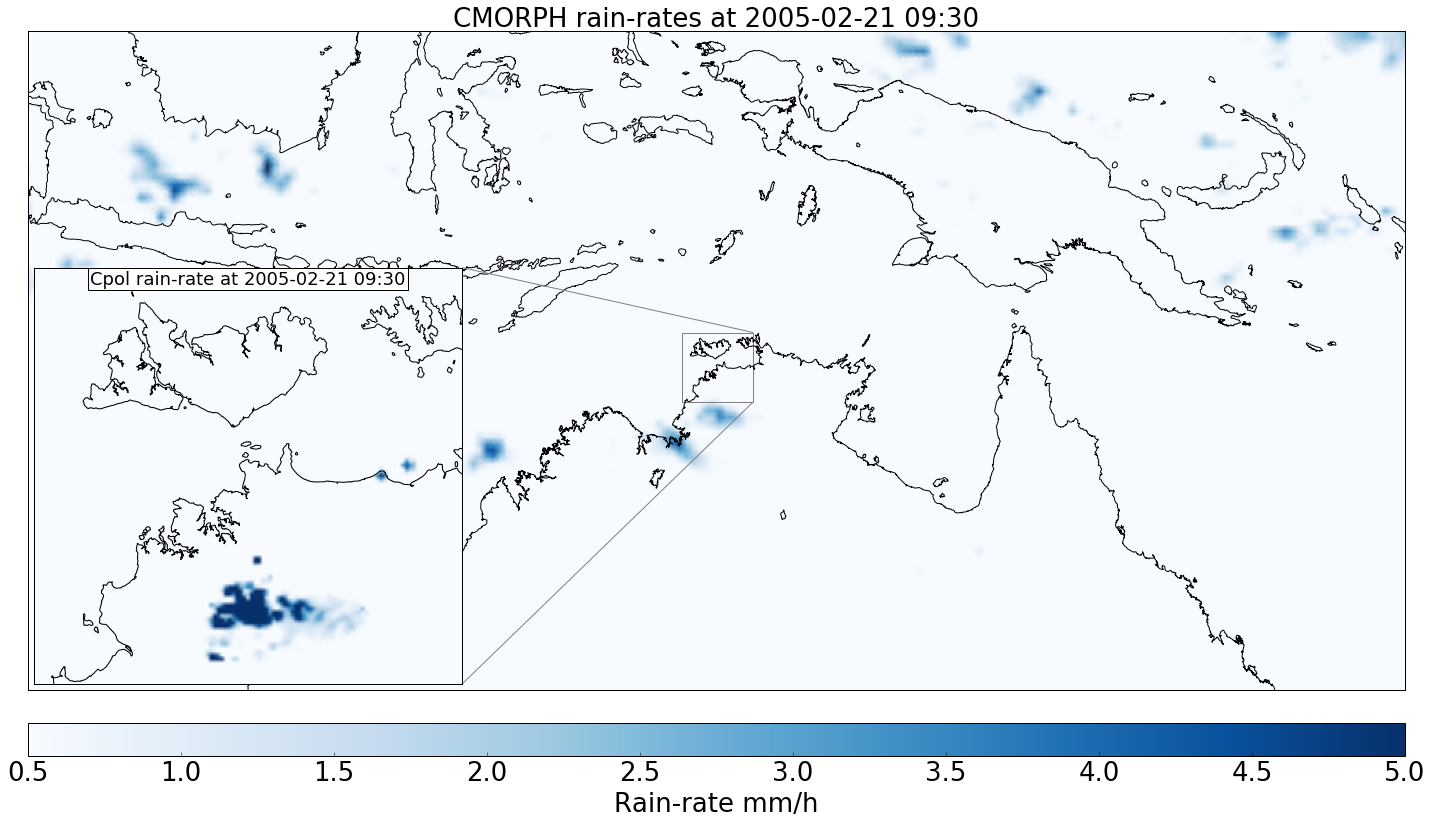

In [49]:
first = True
for i in range(len(rr_cm)):
    outer_title = 'CMORPH rain-rates at %s' %(t_cm[idx[i,-1]]+timedelta(hours=9.5)).strftime('%Y-%m-%d %H:%M')
    inner_title = 'Cpol rain-rate at %s' %(cpol_times['10min'][idx[i,0]]+timedelta(hours=9.5)).strftime('%Y-%m-%d %H:%M')
    try:
        rr_out = rr_cm[i].filled(0) / 3. /2
    except AttributeError:
        rr_out = rr_cm[i] / 3. /2
    if first:
        fig = plt.figure(figsize=(20,15), dpi=72)
        ax = plt.subplot2grid((3,3), (0,0), rowspan=3, colspan=3)
        #ax = plt.subplots(111)
        #ax1 = plt.subplot2grid((3,3), (0,1))
        #ax10 = plt.subplot2grid((3,3), (0,0))
        #ax6 = plt.subplot2grid((3,3), (0,2))
        im = m_cm.pcolormesh(lon_cm, lat_cm, rr_out, vmin=0.5, vmax=5., cmap='Blues', shading='gouraud')
        m_cm.drawcoastlines()
        cbar=m_cm.colorbar(im,location='bottom',pad='5%')
        cbar.set_label('Rain-rate mm/h',size=26)
        cbar.ax.tick_params(labelsize=26)
        axins = zoomed_inset_axes(ax, 6, loc=3)
        axins.set_xlim(min(lon_cp), max(lon_cp))
        axins.set_ylim(min(lat_cp), max(lon_cp))
        #m_cp_i = Basemap(llcrnrlat=min(lat_cp), llcrnrlon=min(lon_cp), urcrnrlat=max(lat_cp), urcrnrlon=max(lon_cp), ax=axins, resolution='i')
        #m_cp_1 = Basemap(llcrnrlat=min(lat_cp), llcrnrlon=min(lon_cp), urcrnrlat=max(lat_cp), urcrnrlon=max(lon_cp), ax=ax1, resolution='i')
        m_cp_10 = Basemap(llcrnrlat=min(lat_cp), llcrnrlon=min(lon_cp), urcrnrlat=max(lat_cp), urcrnrlon=max(lon_cp), ax=axins, resolution='f')
        #m_cp_6 = Basemap(llcrnrlat=min(lat_cp), llcrnrlon=min(lon_cp), urcrnrlat=max(lat_cp), urcrnrlon=max(lon_cp), ax=ax6, resolution='i')
        im_cp_10 = m_cp_10.pcolormesh(lon_cp, lat_cp, rr_cp['10min'][i].filled(0.5), vmin=0.5, vmax=5. ,cmap='Blues',shading='gouraud')
        m_cp_10.drawcoastlines()
        #axins.set_title(inner_title, size=18)
        axins.text(0.5, 0.95, inner_title, verticalalignment='bottom', horizontalalignment='center',
                   transform=axins.transAxes, fontsize=18, bbox={'facecolor':'white', 'alpha':1, 'pad':1.9})
        plt.xticks(visible=False)
        plt.yticks(visible=False)
        mark_inset(ax, axins, loc1=4, loc2=1, fc="none", ec="0.5")
        first = False
    else:
        im_cp_10.set_array(rr_cp['10min'][i].filled(0.5).ravel())
        im.set_array(rr_out.ravel())
        axins.text(0.5, 0.95, inner_title, verticalalignment='bottom', horizontalalignment='center',
                   transform=axins.transAxes, fontsize=18, bbox={'facecolor':'white', 'alpha':1, 'pad':1.9})
        #axins.set_title(inner_title, size=18)
    ax.set_title(outer_title,size=26)
    plt.tight_layout()
    fname=os.path.join(outDir,'comparison-%03i.png'%i)
    fig.savefig(fname, dpi=72, facecolor='w', edgecolor='w', bbox_inches='tight')
    #plt.show()
    #ax1.cla(),ax10,ax.cla(),ax6.cla(), fig.clf(), plt.close()
    #break